In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.FnalHISQMetadata import params as mData

In [3]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites, ratio_correction_factor
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [4]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [10]:
ENSEMBLE = 'Fine-1'
RATIO    = 'R0'
SMSLIST  = ['1S']
MOMLIST  = ['100','200','300','400']
# MOMLIST  = ['000']

In [18]:
for mom in MOMLIST:
    io = RatioIO(ENSEMBLE,RATIO,mom,PathToDataDir=DATA_DIR)

    req = ratio_prerequisites(
        ens      = ENSEMBLE,
        ratio    = RATIO,
        mom      = mom,
        readfrom = DATA_2PT,
        jk       = False
    )

    print(np.exp(-(req['E0']-req['m0'])*io.Ta))
    print(np.exp(-(req['E0']-req['m0'])*io.Ta))

    ff = ratio_correction_factor(RATIO,io.Ta,**req)

    # print(ff)

0.9246253668174869
0.5500994203692772
0.2772860559079932
0.1463317443980845


In [7]:
TMIN    = 2
NSTATES = 1

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
# ---------- chi^2_exp analysis -------------
# chi2_exp = 11.580895911691108 +/- 4.450713233293699 
# p-value [eval] = 0.7312
# p-value [MC]   = 0.7258
# ---------- 1+1 fit in (2, 15) for mes: RA1 of ens: Fine-1 for mom: 100 --------------
Least Square Fit:
  chi2/dof [dof] = 0.62 [14]    Q = 0.86    logGBF = 64.822

Parameters:
        ratio 0   0.542 (23)     [  0.55 (10) ]  
         A_1S 0   0.054 (37)     [    0 ± 1.0 ]  
         B_1S 0   0.070 (39)     [    0 ± 1.0 ]  
       dE_src 0   -1.38 (90)     [ -2.0 (1.0) ]  

Settings:
  svdcut/n = 0/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 44/0.2)
  fitter = scipy_least_squares    method = trf

# red chi2       = 8.21
# aug chi2       = 8.61
# chi2_exp       = 11.58
# chi2/chi_exp 

Text(0.5, 1.0, 'Fine-1 RA1')

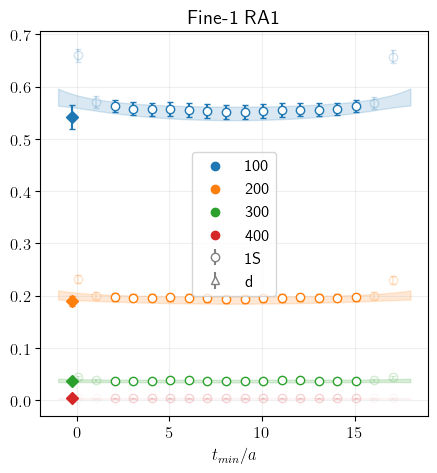

In [8]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(1,1,figsize=(5,5))

f0s = []
for i,mom in enumerate(MOMLIST):
    requisites = ratio_prerequisites(
        ens      = ENSEMBLE,
        ratio    = RATIO,
        mom      = mom,
        readfrom = DATA_2PT,
        jk       = False
    )

    io = RatioIO(ENSEMBLE,RATIO,mom,PathToDataDir=DATA_DIR)
    robj = RatioFitter(
        io,
        jkBin     = BINSIZE[ENSEMBLE],
        smearing  = SMSLIST,
        readfrom  = DATA_2PT,
        **requisites
    )

    trange = (TMIN, robj.Ta-TMIN)

    cov_specs = dict(
        diag   = False,
        block  = False,
        scale  = False,
        shrink = True,
        cutsvd = 1E-12
    )

    dE_src = phys_energy_priors(ENSEMBLE,'Dst',mom,NSTATES,readfrom=DATA_2PT)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,mom,NSTATES,readfrom=DATA_2PT)
    x,ydata = robj.format(trange,flatten=True)
    pr = robj.priors(NSTATES, dE_src=dE_src, dE_snk=dE_snk)

    fit = robj.fit(
        Nstates = NSTATES,
        trange  = trange,
        priors  = pr,
        verbose = False,
        **cov_specs
    )

    res = robj.fit_result(
        Nexc   = NSTATES,
        trange = trange,
        priors = pr 
    )

    alpha = 0.2 if mom=='400' else 1.
    robj.plot_fit(ax,NSTATES,trange,color=f'C{i}',color_res=f'C{i}',alpha=alpha)

    ax.scatter([],[], marker='o', color=f'C{i}', label=mom)


    f0s.append(fit.p['ratio'][0])

ax.errorbar([],[],[],fmt='o', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='1S')
ax.errorbar([],[],[],fmt='^', ecolor='gray', mfc='w', color='gray', capsize=2.5, label='d')

# ax.set_xlim(-0.5,13)
# ax.set_ylim(ymax=0.08)
ax.grid(alpha=0.2)
ax.legend()

ax.set_xlabel(r'$t_{min}/a$')

ax.set_title(f'{ENSEMBLE} {RATIO}')


# plt.savefig(f'/Users/pietro/Desktop/{ENSEMBLE}_{RATIO}_multimom.pdf')